In [10]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import math
from typing import Counter
import copy
import random
import matplotlib.pyplot as plt 


data = np.load("C:\\Users\\baljyot\\Downloads\\mnist.npz")
x_train=data['x_train']
y_train=data['y_train']
x_test=data['x_test']
y_test=data['y_test']

indices_0 = np.where(y_train == 0)[0]
indices_1 = np.where(y_train == 1)[0]

val_indices_0 = indices_0[-1000:]
val_indices_1 = indices_1[-1000:]

train_indices_0 = indices_0[:-1000]
train_indices_1 = indices_1[0:-1000]

total_1=len(train_indices_1)
total_n1=len(train_indices_0)

train_indices = np.concatenate([train_indices_0, train_indices_1])

val_indices = np.concatenate([val_indices_0, val_indices_1])

np.random.shuffle(train_indices)

x_val = np.array(x_train[val_indices])
y_val = np.array(y_train[val_indices])
x_train = np.array(x_train[train_indices])
y_train = np.array(y_train[train_indices])

indices = np.where((y_test == 0) | (y_test == 1))[0]
x_test =np.array(x_test[indices])
y_test = np.array(y_test[indices])


flattened=[]
for i in range(len(x_train)):
    flattened.append(x_train[i].flatten())
x_train=np.array(flattened)
flattened=[]
for i in range(len(x_val)):
    flattened.append(x_val[i].flatten())
x_val=np.array(flattened)
flattened=[]
for i in range(len(x_test)):
    flattened.append(x_test[i].flatten())
x_test=np.array(flattened)


x_train=np.transpose(x_train)
sums=[]
centralisedMean=np.mean(x_train,axis=1)
centralisedData=[]
for i in range(x_train.shape[0]):
    l=[]
    for j in range(x_train.shape[1]):
        l.append(x_train[i][j]- centralisedMean[i])
    centralisedData.append(l)
centralisedMean=np.array(np.mean(centralisedData,axis=1))

S=np.matmul( centralisedData ,np.transpose(centralisedData))/x_train.shape[1]

eigenvalues, eigenvectors = np.linalg.eigh(S)
eigenvalues = eigenvalues[::-1]
U = np.flip(eigenvectors, axis=1)

nUp=U[:,:5]

x_proj=np.matmul(nUp.T,x_train-x_train.mean(axis=1)[:,np.newaxis])

x_test=np.transpose(x_test)
x_proj_test=np.matmul(nUp.T,x_test-x_train.mean(axis=1)[:,np.newaxis])

x_val=np.transpose(x_val)
x_val_proj=np.matmul(nUp.T,x_val-x_train.mean(axis=1)[:,np.newaxis])


x_val=x_val_proj
x_test=x_proj_test
x_train=x_proj


y_train = np.array(y_train).astype(np.int8)
y_val = np.array(y_val).astype(np.int8)
y_test = np.array(y_test).astype(np.int8)

y_train[y_train == 0] = -1
y_val[y_val == 0] = -1
y_test[y_test == 0] = -1



In [11]:
class Region:
   def __init__(self):
      self.one=0
      self.n_one=0
      self.tot_weight=None
      self.misclassified_weight=None
      self.category=None

   def classify(self):
      if (self.one>=self.n_one): self.category=1
      else: self.category=-1

   def make_region_classify(self,one,n_one):
      self.one=one
      self.n_one=n_one
      self.classify()


   def calc_loss(self, weights, x_train, y_train):
      self.misclassified_weight=0
      self.tot_weight=0
      for i in range(len(y_train)):
         self.tot_weight+=weights[i]
         if (y_train[i]!=self.category):
            self.misclassified_weight+=weights[i]
      # print(self.misclassified_weight)

   def remove(self, to_remove, index, y_train, weights):
      remove_class = y_train[index]
      self.tot_weight -= weights[index]
      if remove_class != self.category:
         self.misclassified_weight -= weights[index]
      if remove_class == 1:
         self.one -= 1
      else:
         self.n_one -= 1
      prev_cat = self.category
      self.classify()
      if prev_cat != self.category:
         # print("category changed in removing")
         self.misclassified_weight = self.tot_weight - self.misclassified_weight
   
   def add(self, to_add, index, y_train , weights):
      add_class=y_train[index]
      if (add_class==1):self.one+=1
      else: self.n_one+=1
      prev_cat=self.category
      self.classify()
      if (prev_cat!=self.category):
         # print("category changed in adding")
         self.misclassified_weight = self.tot_weight - self.misclassified_weight
      self.tot_weight+=weights[index]
      if (add_class!=self.category):
          self.misclassified_weight =  self.misclassified_weight+weights[index]

   def print_info(self):
      print("one ",self.one,end="  ")
      print("n_one ",self.n_one,end="  ")
      print("class ", self.category,end="  ")

      print("misclassified ",self.misclassified_weight,end="  ")
      print("tot weight ",self.tot_weight)




In [12]:
class Stump:
    def __init__(self,left,right,cut,dim,loss,alpha):
        self.Left=left 
        self.Right=right 
        self.cut=cut 
        self.dim=dim 
        self.loss=loss 
        self.alpha=alpha 
        

In [13]:
def predict(tree, data):
    if (data[tree.dim]<=tree.cut):
            return tree.Left.category
    else:
        return tree.Right.category

    

def prediction(stumps , data):
    ans=0
    for i in range(len(stumps)):
        ans+=stumps[i].alpha* predict(stumps[i], data)

    if (ans<0):
        return -1
    else:
        return 1


In [14]:
values=[]
weights=np.array([1.0]*(x_train.shape[1]))
num_decesion_tree=300
stumps=[]
minimumm=1000
maximum_accuracy=-1
max_num_tree=0
for st in range(num_decesion_tree):
    total_weight=np.sum(weights)
    # print("total weight for the ", st ,"the stump is : ", total_weight)
    mini_loss=-1
    best_cut=None   
    best_left=None
    best_right=None
    best_dimension=None

    for itr in range(5):
        #all the values are unique so no need to do np.unique() (maybe beacuse of PCA)
        curr=x_train[itr]
        sorted_indices = np.argsort(curr)
        s_vals =curr[sorted_indices]
        s_y_train = y_train[sorted_indices]
        # s_vals=np.unique(np.array(sorted(x_train[i])))
        cut1=(s_vals[0]+s_vals[1])/2
        i_fr_1,i_fr_n1,j_fr_1,j_fr_n1=0,0,0,0
        i_fr=np.where(s_vals==s_vals[0])[0]
        if (s_y_train[0]==1): i_fr_1=1
        else: i_fr_n1=1
        Left=Region()
        Left.make_region_classify(i_fr_1,i_fr_n1)
        
        j_fr_1=total_1-i_fr_1
        j_fr_n1=total_n1-i_fr_n1
        Right=Region()
        Right.make_region_classify(j_fr_1, j_fr_n1)

        Left.misclassified_weight=0
        Left.tot_weight=weights[sorted_indices[0]]
        Right.misclassified_weight=0
        Right.tot_weight=0
        for i in range(1,len(sorted_indices)):
            Right.tot_weight+=weights[sorted_indices[i]]
            if (y_train[sorted_indices[i]]!=Right.category):
                Right.misclassified_weight+=weights[sorted_indices[i]]
        new_loss=Left.misclassified_weight+Right.misclassified_weight

        if (new_loss<=mini_loss or mini_loss==-1):
            mini_loss=new_loss
            best_cut=cut1   
            best_left=copy.deepcopy(Left)
            best_right=copy.deepcopy(Right)
            best_dimension=itr
    
        for j in range(1,len(s_vals)-1):
            cut=(s_vals[j]+s_vals[j+1])/2

            Right.remove(s_vals[j],sorted_indices[j] , y_train,weights)
            Left.add(s_vals[j], sorted_indices[j] , y_train , weights)
            new_loss=Left.misclassified_weight+Right.misclassified_weight
            if (new_loss<=mini_loss or mini_loss==-1):
                mini_loss=new_loss
                best_cut=cut
                best_left=copy.deepcopy(Left)
                best_right=copy.deepcopy(Right)
                best_dimension=itr
    # print()

    loss_ratio=(total_weight-mini_loss)/mini_loss
    alpha=np.log((total_weight-mini_loss)/mini_loss)
    print("stump",st+1,"cut",best_cut, " best dim ", best_dimension,"alpha ",alpha)
    x_train_T=x_train.T
    dim_values = x_train_T[:, best_dimension]

    left_indices = np.where(dim_values <= best_cut)[0]

    right_indices = np.where(dim_values > best_cut)[0]

    


    misclass_left_indices = [index for index in left_indices if y_train[index] != best_left.category]
    misclass_right_indices = [index for index in right_indices if y_train[index] != best_right.category]


    # print(loss_ratio)
    for index in misclass_left_indices:
        weights[index] =(weights[index]) * loss_ratio
        
    for index in misclass_right_indices:
        weights[index] =(weights[index]) * loss_ratio

    tree=Stump(best_left,best_right,best_cut,best_dimension,mini_loss,alpha)
    stumps.append(tree)

    x_new=x_val.T
    acc=[[0,0] for i in range(2) ]
    acc={"-1":[0,0],"1":[0,0]}
    for i in range(x_new.shape[0]):
        acc[str(y_val[i])][1]+=1

        if (prediction(stumps, x_new[i])==y_val[i]):
            acc[str(y_val[i])][0]+=1

    # cate=[-1,1]
    cnt=0
    tot=0
    for i in acc:
        t=acc[i]
        tot+=((t[0]/t[1])*100)
        # print(cate[cnt],":",(t[0]/t[1])*100,"%")
        cnt+=1
    minimumm=min(minimumm,tot/2)
    
    print("Total Accuracy",tot/2,"%")
    values.append(tot/2)
    if (tot/2>maximum_accuracy):
        maximum_accuracy=tot/2
        max_num_tree=st



stump 1 cut 196.10629969876373  best dim  0 alpha  5.399010758105682
Total Accuracy 99.55 %
stump 2 cut -305.0037444588237  best dim  0 alpha  1.0858901576149438
Total Accuracy 99.55 %
stump 3 cut 637.8272710940987  best dim  0 alpha  1.4888908078905678
Total Accuracy 99.55 %
stump 4 cut 337.3657512224445  best dim  2 alpha  1.1000026806204484
Total Accuracy 99.55 %
stump 5 cut 475.24469266725686  best dim  1 alpha  1.0319797451790491
Total Accuracy 99.55 %
stump 6 cut -305.0037444588237  best dim  0 alpha  1.167530341376095
Total Accuracy 99.55 %
stump 7 cut -148.37821234691356  best dim  3 alpha  0.978219958879273
Total Accuracy 99.55 %
stump 8 cut 252.63889625082882  best dim  1 alpha  0.6581598641900991
Total Accuracy 99.55 %
stump 9 cut -305.0037444588237  best dim  0 alpha  0.7612241832593208
Total Accuracy 99.55 %
stump 10 cut 637.8272710940987  best dim  0 alpha  0.6012447802517221
Total Accuracy 99.55 %
stump 11 cut 470.2325962203453  best dim  2 alpha  0.46473549214585846
Tot

In [15]:
print("Maximum Accuracy ",maximum_accuracy,"at the ",max_num_tree+1,"th tree")

Maximum Accuracy  99.69999999999999 at the  91 th tree


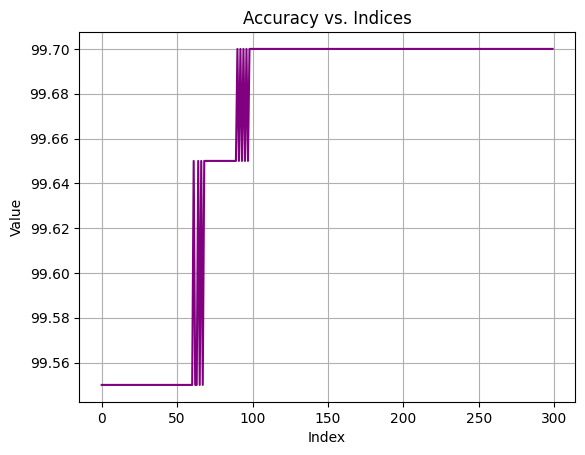

In [16]:

indices = np.arange(len(values))
plt.plot(indices, values, color='purple')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Accuracy vs. Indices')
plt.grid(True)
plt.show()


In [17]:
def find_accuracy(stumps, num,x_test,y_test ):   
    new_stumps=stumps[:num+1]
    x_new=x_test.T
    acc=[[0,0] for i in range(2) ]
    acc={"-1":[0,0],"1":[0,0]}
    for i in range(x_new.shape[0]):
        acc[str(y_test[i])][1]+=1

        if (prediction(new_stumps, x_new[i])==y_test[i]):
            acc[str(y_test[i])][0]+=1


    cnt=0
    tot=0
    for i in acc:
        t=acc[i]
        tot+=((t[0]/t[1])*100)
        print(i,":",(t[0]/t[1])*100,"%")
        cnt+=1

    print("Total Accuracy",tot/2,"%")

In [18]:
find_accuracy(stumps, max_num_tree,x_test,y_test)


-1 : 99.79591836734694 %
1 : 99.64757709251101 %
Total Accuracy 99.72174772992898 %


In [20]:
values=[]
weights=np.array([1.0]*(x_train.shape[1]))
num_decesion_tree=1
stumps=[]
minimumm=1000
maximum_accuracy=-1
max_num_tree=0
for st in range(num_decesion_tree):
    total_weight=np.sum(weights)
    # print("total weight for the ", st ,"the stump is : ", total_weight)
    mini_loss=-1
    best_cut=None   
    best_left=None
    best_right=None
    best_dimension=None

    for itr in range(5):
        #all the values are unique so no need to do np.unique() (maybe beacuse of PCA)
        curr=x_train[itr]
        sorted_indices = np.argsort(curr)
        s_vals =curr[sorted_indices]
        s_y_train = y_train[sorted_indices]
        # s_vals=np.unique(np.array(sorted(x_train[i])))
        cut1=(s_vals[0]+s_vals[1])/2
        i_fr_1,i_fr_n1,j_fr_1,j_fr_n1=0,0,0,0
        i_fr=np.where(s_vals==s_vals[0])[0]
        if (s_y_train[0]==1): i_fr_1=1
        else: i_fr_n1=1
        Left=Region()
        Left.make_region_classify(i_fr_1,i_fr_n1)
        
        j_fr_1=total_1-i_fr_1
        j_fr_n1=total_n1-i_fr_n1
        Right=Region()
        Right.make_region_classify(j_fr_1, j_fr_n1)

        Left.misclassified_weight=0
        Left.tot_weight=weights[sorted_indices[0]]
        Right.misclassified_weight=0
        Right.tot_weight=0
        for i in range(1,len(sorted_indices)):
            Right.tot_weight+=weights[sorted_indices[i]]
            if (y_train[sorted_indices[i]]!=Right.category):
                Right.misclassified_weight+=weights[sorted_indices[i]]
        new_loss=Left.misclassified_weight+Right.misclassified_weight

        if (new_loss<=mini_loss or mini_loss==-1):
            mini_loss=new_loss
            best_cut=cut1   
            best_left=copy.deepcopy(Left)
            best_right=copy.deepcopy(Right)
            best_dimension=itr
    
        for j in range(1,len(s_vals)-1):
            cut=(s_vals[j]+s_vals[j+1])/2

            Right.remove(s_vals[j],sorted_indices[j] , y_train,weights)
            Left.add(s_vals[j], sorted_indices[j] , y_train , weights)
            new_loss=Left.misclassified_weight+Right.misclassified_weight
            if (new_loss<=mini_loss or mini_loss==-1):
                mini_loss=new_loss
                best_cut=cut
                best_left=copy.deepcopy(Left)
                best_right=copy.deepcopy(Right)
                best_dimension=itr
    # print()

    loss_ratio=(total_weight-mini_loss)/mini_loss
    alpha=np.log((total_weight-mini_loss)/mini_loss)
    print("stump",st+1,"cut",best_cut, " best dim ", best_dimension,"alpha ",alpha)
    x_train_T=x_train.T
    dim_values = x_train_T[:, best_dimension]

    left_indices = np.where(dim_values <= best_cut)[0]

    right_indices = np.where(dim_values > best_cut)[0]

    


    misclass_left_indices = [index for index in left_indices if y_train[index] != best_left.category]
    misclass_right_indices = [index for index in right_indices if y_train[index] != best_right.category]


    # print(loss_ratio)
    for index in misclass_left_indices:
        weights[index] =(weights[index]) * loss_ratio
        
    for index in misclass_right_indices:
        weights[index] =(weights[index]) * loss_ratio

    tree=Stump(best_left,best_right,best_cut,best_dimension,mini_loss,alpha)
    stumps.append(tree)

    x_new=x_val.T
    acc=[[0,0] for i in range(2) ]
    acc={"-1":[0,0],"1":[0,0]}
    for i in range(x_new.shape[0]):
        acc[str(y_val[i])][1]+=1

        if (prediction(stumps, x_new[i])==y_val[i]):
            acc[str(y_val[i])][0]+=1

    # cate=[-1,1]
    cnt=0
    tot=0
    for i in acc:
        t=acc[i]
        tot+=((t[0]/t[1])*100)
        # print(cate[cnt],":",(t[0]/t[1])*100,"%")
        cnt+=1
    minimumm=min(minimumm,tot/2)
    
    print("Total Accuracy",tot/2,"%")
    values.append(tot/2)
    if (tot/2>maximum_accuracy):
        maximum_accuracy=tot/2
        max_num_tree=st



stump 1 cut 196.10629969876373  best dim  0 alpha  5.399010758105682
Total Accuracy 99.55 %
